In [ ]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-04-06 08:47:24--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.03s   

2022-04-06 08:47:25 (4.49 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [ ]:
data = pd.read_csv('dataset_sms_spam_v1.csv')
data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


# Text Preprocessing

In [ ]:
'''
Disini, kita tidak banyak melakukan preprocessing karena kita tidak ingin mengubah makna dari suatu kata pada kalimat
'''

import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [ ]:
%time data['clean_teks'] = data['teks'].apply(text_preprocessing)

CPU times: user 19.7 ms, sys: 34 µs, total: 19.8 ms
Wall time: 22.5 ms


In [ ]:
data.sample(5)

,teks,label,clean_teks
462,PT.TRI CARE Selamat!!! simcard anda mendapatka...,1,pttri care selamat simcard anda mendapatkan ha...
796,"Info Gempa Mag:5.3 SR, 21-Jun-16 21:10:23 WIB,...",0,info gempa mag sr jun wib lok ls bt km tengg...
772,Gara gara batman. Pdhl udh diulang,0,gara gara batman pdhl udh diulang
548,Tolong uangnya di transfer saja ke Bank ----- ...,1,tolong uangnya di transfer saja ke bank an ar...
206,"Seru banget main 8 Ball Pool, pakai pulsa bisa...",2,seru banget main ball pool pakai pulsa bisa b...


In [ ]:
data.to_csv('clean_dataset_sms_spam.csv')

# Word Embedding

## Word2Vec

In [ ]:
#import library
import gensim

In [ ]:
# Tokenize kata pada setiap kalimat
def tokenization(text):
  text = re.split('\W+', text)
  return text

sentences = data['clean_teks'].apply(lambda x: tokenization(x.lower()))
sentences

0       [promo, beli, paket, flash, mulai, gb, di, my,...
1       [gb, hari, hanya, rp, ribu, spesial, buat, and...
2       [plg, yth, sisa, kuota, flash, anda, kb, downl...
3       [plg, yth, sisa, kuota, flash, anda, kb, downl...
4       [gb, hari, hanya, rp, ribu, spesial, buat, and...
                              ...                        
1138    [yooo, sama, oke, nanti, aku, umumin, di, grup...
1139    [sebelumnya, ga, ad, nulis, kerudung, kirain, ...
1140                                [mba, mau, kirim, ya]
1141    [nama, beaok, bwrangkat, pagimau, cas, atay, t...
1142                    [no, bri, atas, nama, kamu, mana]
Name: clean_teks, Length: 1143, dtype: object

In [ ]:
# Defenisikan parameter training Word2Vec

MIN_COUNT = 1       # Mengabaikan semua kata dengan frekuensi total lebih rendah dari ini (opsional)
WINDOW = 5          # Window size. Jarak maksimum antara kata saat ini dan yang diprediksi dalam sebuah kalimat.
EPOCH = 10          # Jumlah iterasi (epoch).
SG = 1              # Algoritma pelatihan: 1 untuk skip-gram, 0 untuk CBOW.
SIZE = 5            # Dimensi vektor

In [ ]:
# Proses training Word2Vec

%%time 
model_word2vec = gensim.models.Word2Vec(sentences, size=SIZE, sg=SG, min_count=MIN_COUNT, window=WINDOW, iter=EPOCH)

CPU times: user 1.8 s, sys: 13.6 ms, total: 1.81 s
Wall time: 1.41 s


In [ ]:
# Save model
path = "word2vec.bin.gz"
model_word2vec.wv.save_word2vec_format(path, binary=True)

In [ ]:
# Cari nilai vektor dari kata 'hadiah'
model_word2vec.wv['hadiah']

array([-3.0626292 , -1.091168  ,  0.96953523,  1.1568904 , -0.38226077],
      dtype=float32)

In [ ]:
# Menemukan kata kata teratas yang paling mirip.
# Menghitung kesamaan dari vektor bobot proyeksi dari kata-kata yang diberikan dan vektor untuk setiap kata dalam model.

model_word2vec.wv.most_similar('hadiah')

[('rpjt', 0.9995364546775818),
 ('mdpt', 0.9975308179855347),
 ('tunai', 0.9962599873542786),
 ('noanda', 0.9960152506828308),
 ('mendptkan', 0.9954967498779297),
 ('mdptkan', 0.9927559494972229),
 ('meraih', 0.9923599362373352),
 ('ptmkios', 0.990911602973938),
 ('dri', 0.9906704425811768),
 ('rpjuta', 0.9906392097473145)]

In [ ]:
# Karena berdimensi 5, kita membutuhkan
# Kata-kata yang ingin kita plot vektornya
word_list = ['hadiah', 'promosi', 'sms', 'malam', 'makan', 'telkomsel', 'selamat', 'juta', 'nama', 'duit', 'uang']

# daftar vektor dari kata-kata tersebut
word_vectors = np.array([model_word2vec.wv[w] for w in word_list])
word_vectors

array([[-3.0626292 , -1.091168  ,  0.96953523,  1.1568904 , -0.38226077],
       [-0.562328  , -0.7723203 , -0.11863454,  0.25537527, -0.08646997],
       [-1.4384586 , -0.89521   , -0.54561573,  0.81943905,  0.96765614],
       [-1.1365757 , -1.002006  , -0.5045147 ,  0.5037394 , -0.14634486],
       [-0.77046824, -1.1652234 , -0.35917884,  0.31536502, -0.05939662],
       [-1.1955974 , -1.0835694 , -0.40923533,  0.71755373, -0.15231471],
       [-2.692903  , -0.557634  ,  0.14114828,  1.4422382 , -0.71086836],
       [-1.7686254 , -0.939259  ,  0.3641457 ,  0.7558175 ,  0.00432832],
       [-0.67958224, -1.5676935 , -0.51492584, -0.2027517 , -0.19711724],
       [-0.5068055 , -0.7503509 , -0.15279661,  0.22327954, -0.11866228],
       [-1.7069782 , -0.9977563 ,  0.19260845,  0.59024787, -0.08390077]],
      dtype=float32)

In [ ]:
# Reduksi dimensi vektor ke 2D menggunakan PCA
from sklearn.decomposition import PCA, KernelPCA

dimred = PCA(n_components=2, copy=False, whiten=True)
red_word_vectors = dimred.fit_transform(word_vectors)

In [ ]:
red_word_vectors

array([[ 1.9524572 , -0.57931936],
       [-0.8050187 , -0.47626692],
       [-0.20702258,  2.83551   ],
       [-0.40064964,  0.08887029],
       [-0.73989266, -0.21790065],
       [-0.24120241,  0.1599069 ],
       [ 1.5621014 , -0.16710064],
       [ 0.5000875 ,  0.04523466],
       [-1.0851793 , -0.97940797],
       [-0.86764014, -0.54915607],
       [ 0.33196068, -0.16037023]], dtype=float32)

In [ ]:
# Implementasi visualisasi dapat di cek pada laman berikut: https://ir.cs.ui.ac.id/alfan/tutorial/gensim_w2v.html

def plot(datas, labels, fc='yellow'):
  # plot the dots
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(datas[:, 0], datas[:, 1], marker='o')

  # annotate labels
  for label, x, y in zip(labels, datas[:, 0], datas[:, 1]):
    plt.annotate(label, \
                 xy=(x, y), xytext=(-15, 15), \
                 textcoords='offset points', ha='right', va='bottom', \
                 bbox=dict(boxstyle='round,pad=0.3', fc=fc, alpha=0.5), \
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.show()

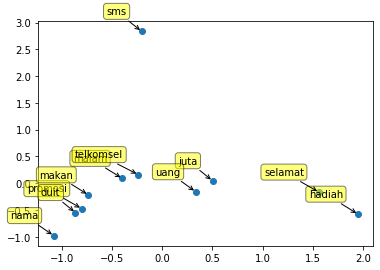

In [ ]:
plot(red_word_vectors, word_list)

## FastText

In [ ]:
!pip -q install fasttext

     |████████████████████████████████| 68 kB 4.1 MB/s 


In [ ]:
# Download dan unzip dataset
# Warning: proses download lama dan memakan diskspace yang besar
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2022-04-06 02:48:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  93.1MB/s    in 49s     

2022-04-06 02:49:32 (87.7 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
import fasttext
ft_model = fasttext.load_model("cc.en.300.bin")

In [ ]:
print(ft_model['hadiah'])

[ 2.31886618e-02 -9.02718380e-02 -3.26942317e-02  4.43942025e-02
  1.16834603e-01  1.29350051e-01 -1.75389405e-02  1.32096335e-01
 -1.11069754e-01  9.42594651e-03 -1.92331269e-01  4.87022214e-02
 -5.89958690e-02 -2.72452720e-02  2.42144074e-02  2.68125534e-03
 -6.44036084e-02  8.76408350e-03 -7.87095428e-02  5.56880720e-02
 -5.49955964e-02 -2.05840413e-02  2.97657382e-02 -1.48930848e-02
  5.00083379e-02  5.20066731e-02  5.92291020e-02  9.67174694e-02
  1.05014993e-02  2.70687371e-01  2.61476841e-02 -9.76984128e-02
 -3.81510258e-02 -5.54437637e-02  1.40345320e-02  5.98153472e-02
  2.05978937e-02  6.20838888e-02 -4.92071509e-02  4.86903377e-02
 -8.15637633e-02  9.45009813e-02  4.54714634e-02  2.62403525e-02
 -3.23774070e-02  3.31735723e-02 -2.53115129e-02  3.84174590e-03
 -2.66067982e-02 -3.60902213e-02  2.70026959e-02 -3.82749140e-02
 -1.75837670e-02  8.24360400e-02 -1.41439915e-01 -6.02689497e-02
 -1.00951986e-02  2.63172835e-02  3.92115526e-02  3.08932569e-02
  5.78716993e-02 -1.84465

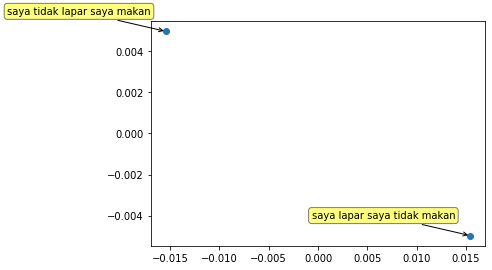

In [ ]:
list_kalimat = ['saya lapar saya tidak makan','saya tidak lapar saya makan'] 
word_vectors_fasttext = np.array([ft_model[w] for w in list_kalimat])
pca = PCA(n_components=2, copy=False, whiten=True)

fasttext_word_vectors = pca.fit_transform(word_vectors_fasttext)

plot(word_vectors_fasttext, list_kalimat)

# Deep Learning for NLP

## LSTM

### Data Splitting

In [ ]:
# Tentukan kolom yang akan digunkan
data = data[['clean_teks', 'label']]
data

,clean_teks,label
0,promo beli paket flash mulai gb di my telkomse...,2
1,gb hari hanya rp ribu spesial buat anda yang ...,2
2,plg yth sisa kuota flash anda kb download myte...,2
3,plg yth sisa kuota flash anda kb download myte...,2
4,gb hari hanya rp ribu spesial buat anda yang ...,2
...,...,...
1138,yooo sama oke nanti aku umumin di grup kelas,0
1139,sebelumnya ga ad nulis kerudung kirain warna jins,0
1140,mba mau kirim ya,0
1141,nama beaok bwrangkat pagimau cas atay tranfer,0


In [ ]:
# Buat data uji, data latih, dan data validasi
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=5)
data_train, data_val = train_test_split(data_train, test_size=0.25, random_state=5)

In [ ]:
# Lihat shape dari masing-masing data
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(685, 2)
(229, 2)
(229, 2)


In [ ]:
# Pisahkan kolom fitur dan target (label)
trainX = np.array(data_train.iloc[:, 0])
trainY = np.array(data_train.iloc[:, 1])

testX = np.array(data_test.iloc[:, 0])
testY = np.array(data_test.iloc[:, 1])

valX = np.array(data_val.iloc[:, 0])
valY = np.array(data_val.iloc[:, 1])

In [ ]:
# One-hot encoding

trainY = pd.get_dummies(trainY).values
testY = pd.get_dummies(testY).values
valY = pd.get_dummies(valY).values

In [ ]:
print(trainY.shape)
print(testY.shape)
print(valY.shape)

(685, 3)
(229, 3)
(229, 3)


In [ ]:
trainY

### Tokenizing Data

In [ ]:
'''
Proses vektorisasi teks dengan mengubah setiap teks menjadi token urutan bilangan int (setiap bilangan int menjadi indeks token dalam dictionary) 
'''
from keras.preprocessing.text import Tokenizer

In [ ]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan >=100 tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=100, oov_token=OOV_TOKEN, lower=True)   
tokenizer.fit_on_texts(trainX)

# Tambahkan token padding untuk menyamakan ukuran dimensi fitur input ke LSTM
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

word_index = tokenizer.word_index

In [ ]:
# Lihat dictionary yang telah dibuat proses tokenisasi
print(word_index)

{'<unk>': 1, 'di': 2, 'anda': 3, 'ke': 4, 'info': 5, 'ini': 6, 'yg': 7, 'aku': 8, 'mau': 9, 'ada': 10, 'hadiah': 11, 'sms': 12, 'cek': 13, 'rp': 14, 'nama': 15, 'dan': 16, 'dari': 17, 'pin': 18, 'paket': 19, 'klik': 20, 'pulsa': 21, 'no': 22, 'aja': 23, 'hub': 24, 'ya': 25, 'hari': 26, 'untuk': 27, 'rb': 28, 'kalau': 29, 'selamat': 30, 'atau': 31, 'promo': 32, 'dr': 33, 'saya': 34, 'gb': 35, 'utk': 36, 'yang': 37, 'kuota': 38, 'jt': 39, 'resmi': 40, 'pemenang': 41, 'dengan': 42, 'isi': 43, 'tri': 44, 'uinfo': 45, 'gratis': 46, 'sd': 47, 'indosat': 48, 'care': 49, 'bisa': 50, 'ketik': 51, 'berlaku': 52, 'hanya': 53, 'ulang': 54, 'jam': 55, 'beli': 56, 'kamu': 57, 'telah': 58, 'nomor': 59, 'ga': 60, 'sudah': 61, 'pak': 62, 'nya': 63, 'bonus': 64, 'dgn': 65, 'nanti': 66, 'kami': 67, 'maaf': 68, 'kasih': 69, 'internetan': 70, 'bb': 71, 'kalo': 72, 'dg': 73, 'yth': 74, 'poin': 75, 'dulu': 76, 'nikmati': 77, 'mobil': 78, 'juga': 79, 'tapi': 80, 'internet': 81, 'pesan': 82, 'teh': 83, 'unit':

In [ ]:
len(word_index)

3151

### Text to Sequences

In [ ]:
'''
Proses mengubah token teks menjadi urutan bilangan int.
'''
train_seqs = tokenizer.texts_to_sequences(trainX)
val_seqs = tokenizer.texts_to_sequences(valX)
test_seqs = tokenizer.texts_to_sequences(testX)

In [ ]:
# Lihat hasil dari text to sequences
# Setiap bilang int merujuk pada indeks token yang ada dalam dictionary
print(train_seqs)

[[1, 22, 3, 1, 11, 14, 1, 17, 1, 75, 1, 1, 1, 1, 1, 2, 1, 24, 1, 1, 1], [1, 49, 30, 1, 3, 91, 11, 84, 1, 1, 42, 18, 1, 27, 5, 20], [30, 3, 1, 11, 14, 1, 17, 1, 1, 1, 1, 24, 1, 1], [68, 1, 29, 1, 1, 31, 1, 25], [1, 1, 1, 12, 1, 36, 1, 12, 1, 1, 1, 1, 1, 1, 32, 14, 1, 1, 1, 55], [92, 69, 58, 1, 1, 1, 9, 1, 1, 1, 1, 1, 64, 46, 96, 1], [8, 1, 1, 1, 1], [1, 8, 1, 1, 1, 1, 33, 1, 56, 97, 1, 1, 7, 50, 1, 1, 1, 1, 1, 1], [1, 1, 8, 1, 76], [77, 1, 2, 1, 1, 1, 26, 1, 65, 1, 1, 1, 52, 5, 1], [1, 1, 23, 7, 9, 1, 1, 7, 1, 1, 1], [1, 29, 10, 37, 1, 1, 31, 1], [1, 1, 57, 7, 1, 70, 1, 28, 1, 1, 70, 1, 1, 38, 35, 1, 51, 1, 4, 1, 47, 1, 59, 6], [1, 66, 1, 55, 98, 1, 60, 1, 26, 6], [1, 22, 3, 1, 78, 1, 33, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 67], [1, 66, 34, 1, 42, 1, 1, 99, 7, 1, 1], [69, 1, 23, 1, 1, 1, 10, 7, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 29, 10, 1, 1, 1, 1], [1, 1, 1, 1, 37, 1, 1, 10, 1, 1, 42, 1, 1, 2, 1, 1, 1, 46, 2], [1, 1, 15, 1, 15, 1, 1, 1, 1], [1, 1, 1, 14, 28, 36, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
print(trainX[10])
print(train_seqs[10])

paling seikhlasnya aja yg mau nyumbang mangga yg ngga mangga gt
[1, 1, 23, 7, 9, 1, 1, 7, 1, 1, 1]


### Padding & Truncate

In [ ]:
'''
Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps). 
num_timesteps adalah argumen maxlen jika disediakan, atau panjang dari sequence terpanjang dalam daftar.

Sequence yang lebih pendek dari num_timesteps diisi dengan nilai hingga panjangnya sama dengan num_timesteps (padding).
Sequence yang lebih panjang dari num_timesteps dipotong sehingga sesuai dengan panjang yang diinginkan (truncate).
'''

from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Lihat distribusi jumlah kata dalam X_train_seq.
# Pada contoh ini, max_len tidak ditentukan, sehingga semua data dari sequence akan di padding menjad panjang sesuai dengan sequnce terpanjang
l = [len(i) for i in train_seqs]
l = np.array(l)

print('minimum number of words: {}'.format(l.min()))
print('median number of words: {}'.format(np.median(l)))
print('average number of words: {}'.format(l.mean()))
print('maximum number of words: {}'.format(l.max()))

minimum number of words: 2
median number of words: 16.0
average number of words: 15.766423357664234
maximum number of words: 59


In [ ]:
PADDING = 'pre' # Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.

train_seqs = pad_sequences(train_seqs, padding=PADDING)
val_seqs = pad_sequences(val_seqs, padding=PADDING)
test_seqs = pad_sequences(test_seqs, padding=PADDING)

In [ ]:
print(trainX[10])
print(train_seqs[10])

paling seikhlasnya aja yg mau nyumbang mangga yg ngga mangga gt
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  1 23  7  9  1  1  7  1  1  1]


### Define Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten

model_LSTM = Sequential()
model_LSTM.add(Embedding(len(word_index), 200))
model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(3, activation='softmax'))

In [ ]:
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [ ]:
%%time

EPOCH = 10
BATCH_SIZE = 64

history_LSTM = model_LSTM.fit(train_seqs, trainY, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(val_seqs, valY))

Epoch 1/10
11/11 [==============================] - 5s 192ms/step - loss: 1.0291 - accuracy: 0.4599 - val_loss: 0.8164 - val_accuracy: 0.6288
Epoch 2/10
11/11 [==============================] - 1s 132ms/step - loss: 0.8075 - accuracy: 0.6555 - val_loss: 0.6179 - val_accuracy: 0.7336
Epoch 3/10
11/11 [==============================] - 1s 129ms/step - loss: 0.6938 - accuracy: 0.7474 - val_loss: 0.5814 - val_accuracy: 0.7380
Epoch 4/10
11/11 [==============================] - 1s 127ms/step - loss: 0.5766 - accuracy: 0.7591 - val_loss: 0.4874 - val_accuracy: 0.8384
Epoch 5/10
11/11 [==============================] - 1s 129ms/step - loss: 0.4327 - accuracy: 0.8423 - val_loss: 0.3910 - val_accuracy: 0.8690
Epoch 6/10
11/11 [==============================] - 1s 130ms/step - loss: 0.3255 - accuracy: 0.8861 - val_loss: 0.3644 - val_accuracy: 0.8821
Epoch 7/10
11/11 [==============================] - 1s 129ms/step - loss: 0.2791 - accuracy: 0.9051 - val_loss: 0.3493 - val_accuracy: 0.8865
Epoch 

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

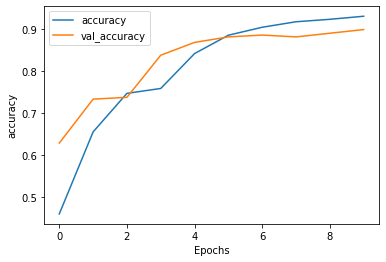

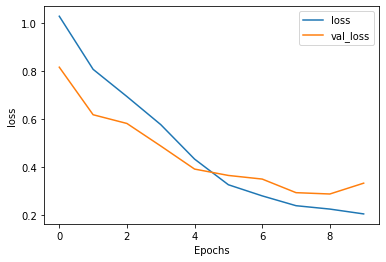

In [ ]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_LSTM.history['accuracy'][i], history_LSTM.history['loss'][i], history_LSTM.history['val_accuracy'][i], history_LSTM.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.459854 	   1.029103 	   0.628821 	   0.816379
       2   0.655474 	   0.807492 	   0.733624 	   0.617878
       3   0.747445 	   0.693827 	   0.737991 	   0.581406
       4   0.759124 	   0.576622 	   0.838428 	   0.487359
       5   0.842336 	   0.432699 	   0.868996 	   0.390997
       6   0.886131 	   0.325549 	   0.882096 	   0.364394
       7   0.905109 	   0.279083 	   0.886463 	   0.349262
       8   0.918248 	   0.238100 	   0.882096 	   0.292514
       9   0.924088 	   0.223986 	   0.890830 	   0.286935
      10   0.931387 	   0.203773 	   0.899563 	   0.332157


### Evaluate

In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM.predict(test_seqs), axis=1)
y_true = np.argmax(testY, axis=1)

loss, accuracy = model_LSTM.evaluate(test_seqs, testY)

8/8 [==============================] - 1s 28ms/step - loss: 0.2604 - accuracy: 0.8952


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       116
           1       0.89      0.90      0.89        70
           2       0.85      0.79      0.82        43

    accuracy                           0.90       229
   macro avg       0.88      0.87      0.88       229
weighted avg       0.89      0.90      0.89       229



## LSTM + Word Embedding

In [ ]:
# Load word2vec
from gensim.models import KeyedVectors

reloaded_word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
print(reloaded_word_vectors.vocab)

{'di': <gensim.models.keyedvectors.Vocab object at 0x7f7e082bbed0>, 'anda': <gensim.models.keyedvectors.Vocab object at 0x7f7e082bb990>, 'ke': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246090>, 'ini': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246110>, 'info': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246190>, 'ada': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246250>, 'yg': <gensim.models.keyedvectors.Vocab object at 0x7f7e082462d0>, 'aku': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246350>, 'mau': <gensim.models.keyedvectors.Vocab object at 0x7f7e082463d0>, 'dan': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246410>, 'hadiah': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246450>, 'dari': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246510>, 'sms': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246590>, 'no': <gensim.models.keyedvectors.Vocab object at 0x7f7e08246610>, 'klik': <gensim.models.keyedvectors.Vocab obj

### Token to Embedding

In [ ]:
# Buat fungsi untuk mengubah kata pada kalimat sesuai dengan word2vec, gunakan token kalimat sebagai input 'sentences'
def embed(token_kalimat):
  embedding = []
  for sentences in token_kalimat:
    sentencevec = []
    for w in sentences:
      if w in reloaded_word_vectors.vocab:
        sentencevec.append(reloaded_word_vectors[w])
      else :
        sentencevec.append(np.zeros((5)))
    embedding.append(sentencevec)
  return embedding

### Padding

In [ ]:
# Buat fungsi untuk melakukan padding

max_length = 100

def padding(vec):
  padded = []
  for i, v in enumerate(vec) :
    vector = []
    if len(v) < max_length :
      pad_count = max_length - len(v)
      pad = np.zeros((pad_count, 5))
      vector = np.append(v, pad, axis=0)
    else :
      vector = v[:max_length]
    padded.append(vector)
  return padded

In [ ]:
trainX_we = embed(trainX)
testX_we = embed(testX)
valX_we = embed(valX)

trainX_we = np.array(padding(trainX_we))
testX_we = np.array(padding(testX_we))
valX_we = np.array(padding(valX_we))

In [ ]:
print(trainX_we.shape)
print(testX_we.shape)
print(valX_we.shape)

(685, 100, 5)
(229, 100, 5)
(229, 100, 5)


### Define Model

In [ ]:
model_LSTM_we = Sequential()
model_LSTM_we.add(LSTM(100, return_sequences=True, input_shape=(100,5)))
model_LSTM_we.add(Dense(3, activation='softmax'))

In [ ]:
model_LSTM_we.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100, 100)          42400     
                                                                 
 dense_1 (Dense)             (None, 100, 3)            303       
                                                                 
Total params: 42,703
Trainable params: 42,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

EPOCH = 10
BATCH_SIZE = 64

history_LSTM = model_LSTM.fit(train_seqs, trainY, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(val_seqs, valY))

Epoch 1/10
11/11 [==============================] - 1s 134ms/step - loss: 0.1873 - accuracy: 0.9343 - val_loss: 0.4102 - val_accuracy: 0.8865
Epoch 2/10
11/11 [==============================] - 1s 131ms/step - loss: 0.1612 - accuracy: 0.9372 - val_loss: 0.3584 - val_accuracy: 0.8996
Epoch 3/10
11/11 [==============================] - 1s 129ms/step - loss: 0.1439 - accuracy: 0.9431 - val_loss: 0.3292 - val_accuracy: 0.9039
Epoch 4/10
11/11 [==============================] - 1s 129ms/step - loss: 0.1374 - accuracy: 0.9489 - val_loss: 0.3180 - val_accuracy: 0.9083
Epoch 5/10
11/11 [==============================] - 1s 129ms/step - loss: 0.1418 - accuracy: 0.9533 - val_loss: 0.3388 - val_accuracy: 0.8821
Epoch 6/10
11/11 [==============================] - 1s 132ms/step - loss: 0.1378 - accuracy: 0.9504 - val_loss: 0.4072 - val_accuracy: 0.8865
Epoch 7/10
11/11 [==============================] - 1s 131ms/step - loss: 0.1301 - accuracy: 0.9620 - val_loss: 0.4623 - val_accuracy: 0.8734
Epoch 

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

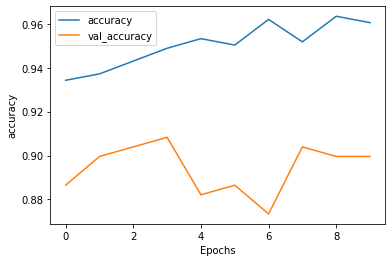

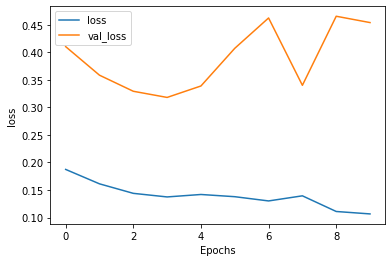

In [ ]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_LSTM.history['accuracy'][i], history_LSTM.history['loss'][i], history_LSTM.history['val_accuracy'][i], history_LSTM.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.934307 	   0.187324 	   0.886463 	   0.410215
       2   0.937226 	   0.161158 	   0.899563 	   0.358377
       3   0.943066 	   0.143885 	   0.903930 	   0.329188
       4   0.948905 	   0.137379 	   0.908297 	   0.318014
       5   0.953285 	   0.141828 	   0.882096 	   0.338793
       6   0.950365 	   0.137813 	   0.886463 	   0.407154
       7   0.962044 	   0.130113 	   0.873362 	   0.462259
       8   0.951825 	   0.139392 	   0.903930 	   0.340014
       9   0.963504 	   0.110961 	   0.899563 	   0.465389
      10   0.960584 	   0.106548 	   0.899563 	   0.453890


In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM.predict(test_seqs), axis=1)
y_true = np.argmax(testY, axis=1)

loss, accuracy = model_LSTM.evaluate(test_seqs, testY)

8/8 [==============================] - 0s 14ms/step - loss: 0.3868 - accuracy: 0.8734


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       122
           1       0.85      0.90      0.87        67
           2       0.78      0.78      0.78        40

    accuracy                           0.87       229
   macro avg       0.85      0.85      0.85       229
weighted avg       0.87      0.87      0.87       229

